In [1]:
# Add project path to the PYTHONPATH

import os
import sys
import numpy as np
from pathlib import Path

sys.path.append(Path(os.path.join(os.path.abspath(''), '../')).resolve().as_posix())

In [2]:
import pickle

In [3]:
from time import time

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [5]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return fig, ax

## Load Test Set

Load the test dataset

In [6]:
from nlp.dataset import Dataset

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/rmohashi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
dataset = Dataset('/home/rmohashi/hd/sentiment140/test_data.csv')
dataset.load()
dataset.preprocess_texts()
data = dataset.cleaned_data.copy()

Time to clean up: 0.11 sec


In [8]:
x_test = data.text
y_test = data.label.astype('int')

In [9]:
import seaborn as sns

In [10]:
labeled_data = data.copy()
labeled_data.label = data.label.apply(lambda x: "positivo" if x == 4 else "negativo")

[Text(0, 0.5, 'Número de tweets'), Text(0.5, 0, 'Rótulo')]

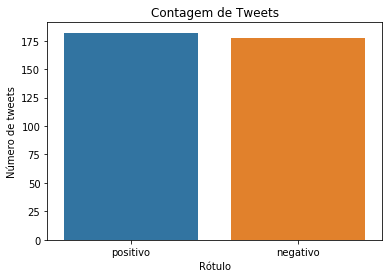

In [11]:
ax = sns.countplot(x='label', data=labeled_data)
ax.set_title('Contagem de Tweets')
ax.set(xlabel='Rótulo', ylabel='Número de tweets')

## Load Model

Load the trained naive bayes - sentiment analysis model

In [12]:
filepath = Path('../models/sentiment_analysis/nb_model.pickle').resolve()
with filepath.open('rb') as file:
    model = pickle.load(file)

## Naive Bayes

In [13]:
from sklearn.metrics import classification_report

In [14]:
results = model.predict(x_test)
print(classification_report(y_test, results, digits=4))

              precision    recall  f1-score   support

           0     0.8218    0.8079    0.8148       177
           4     0.8162    0.8297    0.8229       182

    accuracy                         0.8189       359
   macro avg     0.8190    0.8188    0.8189       359
weighted avg     0.8190    0.8189    0.8189       359



Confusion matrix
[[0.8079096  0.1920904 ]
 [0.17032967 0.82967033]]


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7258406990>)

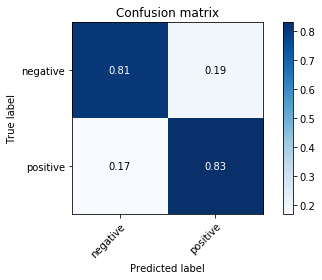

In [15]:
nb_y_test = y_test.apply(lambda x: 1 if x == 4 else 0)
nb_results = np.where(results != 4, results, 1)
classes = np.array(['negative', 'positive'])
plot_confusion_matrix(nb_y_test, nb_results, classes, normalize=True)

## Neural Networks

In [16]:
import pickle
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

/home/rmohashi/miniconda3/envs/emodata/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/rmohashi/miniconda3/envs/emodata/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/rmohashi/miniconda3/envs/emodata/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/rmohashi/miniconda3/envs/emo

In [17]:
from sentiment_analysis.models.lstm_model import lstm_model
from sentiment_analysis.models.cnn_model import cnn_model
from sentiment_analysis.models.lstm_conv_model import lstm_conv_model

In [18]:
tokenizer_path = Path('/home/rmohashi/hd/sentiment140/tokenizer.pickle').resolve()

In [19]:
with tokenizer_path.open('rb') as file:
    tokenizer = pickle.load(file)

In [20]:
sequences = [text.split() for text in data.text]
list_tokenized = tokenizer.texts_to_sequences(sequences)

In [21]:
y_test = data.label.replace(4, 1)

### 100d - GloVe

In [22]:
input_dim = len(tokenizer.word_index) + 1

In [23]:
input_length = 30
embedding_dim = 100

#### LSTM

In [24]:
model_weights_path = Path('/home/rmohashi/hd/tweet-emotion-recognition/models/sentiment_analysis/checkpoints/LSTM_100_30_GloVe/lstm_100_30_03-0.8184.h5').resolve()

In [25]:
model = lstm_model(input_length, input_dim, None, embedding_dim=embedding_dim)
model.load_weights(model_weights_path.as_posix())
x_test = pad_sequences(list_tokenized, maxlen=input_length)
y_pred = model.predict(x_test)
y_pred = y_pred.round()
print(classification_report(y_test, y_pred, digits=4))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
              precision    recall  f1-score   support

           0     0.8443    0.7966    0.8198       177
           1     0.8125    0.8571    0.8342       182

    accuracy                         0.8273       359
   macro avg     0.8284    0.8269    0.8270       359
weighted avg     0.8282    0.8273    0.8271       359



Confusion matrix
[[0.79661017 0.20338983]
 [0.14285714 0.85714286]]


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f71f2cece10>)

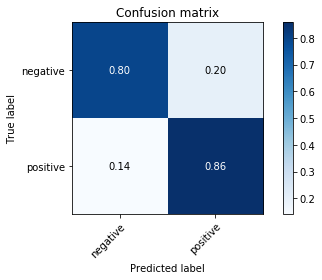

In [26]:
plot_confusion_matrix(y_test, y_pred, classes, normalize=True)

#### CNN

In [27]:
model_weights_path = Path('/home/rmohashi/hd/tweet-emotion-recognition/models/sentiment_analysis/checkpoints/CNN_100_30_GloVe/cnn_100_30_04-0.8138.h5').resolve()

In [28]:
model = cnn_model(input_length, input_dim, None, embedding_dim=embedding_dim)
model.load_weights(model_weights_path.as_posix())
x_test = pad_sequences(list_tokenized, maxlen=input_length)
y_pred = model.predict(x_test)
y_pred = y_pred.round()
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8343    0.8249    0.8295       177
           1     0.8315    0.8407    0.8361       182

    accuracy                         0.8329       359
   macro avg     0.8329    0.8328    0.8328       359
weighted avg     0.8329    0.8329    0.8329       359



Confusion matrix
[[0.82485876 0.17514124]
 [0.15934066 0.84065934]]


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f72175005d0>)

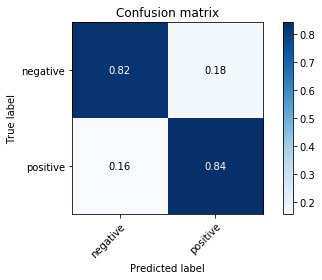

In [29]:
plot_confusion_matrix(y_test, y_pred, classes, normalize=True)

#### LSTM-CNN

In [30]:
model_weights_path = Path('/home/rmohashi/hd/tweet-emotion-recognition/models/sentiment_analysis/checkpoints/LSTM_Conv_100_30_GloVe/lstm_conv_100_30_04-0.8169.h5').resolve()

In [31]:
model = lstm_conv_model(input_length, input_dim, None, embedding_dim=embedding_dim)
model.load_weights(model_weights_path.as_posix())
x_test = pad_sequences(list_tokenized, maxlen=input_length)
y_pred = model.predict(x_test)
y_pred = y_pred.round()
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8443    0.7966    0.8198       177
           1     0.8125    0.8571    0.8342       182

    accuracy                         0.8273       359
   macro avg     0.8284    0.8269    0.8270       359
weighted avg     0.8282    0.8273    0.8271       359



Confusion matrix
[[0.79661017 0.20338983]
 [0.14285714 0.85714286]]


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7212052050>)

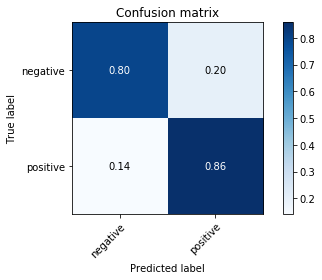

In [32]:
plot_confusion_matrix(y_test, y_pred, classes, normalize=True)

### 50d - no GloVe

In [33]:
input_dim = tokenizer.num_words
embedding_dim = 50

#### LSTM

In [34]:
model_weights_path = Path('/home/rmohashi/hd/tweet-emotion-recognition/models/sentiment_analysis/checkpoints/LSTM_50_30/lstm_50_30_02-0.8137.h5').resolve()

In [35]:
model = lstm_model(input_length, input_dim, None, embedding_dim=embedding_dim)
model.load_weights(model_weights_path.as_posix())
x_test = pad_sequences(list_tokenized, maxlen=input_length)
y_pred = model.predict(x_test)
y_pred = y_pred.round()
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8284    0.7910    0.8092       177
           1     0.8053    0.8407    0.8226       182

    accuracy                         0.8162       359
   macro avg     0.8168    0.8158    0.8159       359
weighted avg     0.8167    0.8162    0.8160       359



Confusion matrix
[[0.79096045 0.20903955]
 [0.15934066 0.84065934]]


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f71f3b9bc10>)

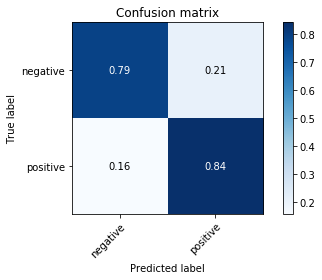

In [36]:
plot_confusion_matrix(y_test, y_pred, classes, normalize=True)

#### CNN

In [37]:
model_weights_path = Path('/home/rmohashi/hd/tweet-emotion-recognition/models/sentiment_analysis/checkpoints/CNN_50_30/cnn_50_30_04-0.8117.h5').resolve()

In [38]:
model = cnn_model(input_length, input_dim, None, embedding_dim=embedding_dim)
model.load_weights(model_weights_path.as_posix())
x_test = pad_sequences(list_tokenized, maxlen=input_length)
y_pred = model.predict(x_test)
y_pred = y_pred.round()
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8598    0.7966    0.8270       177
           1     0.8154    0.8736    0.8435       182

    accuracy                         0.8357       359
   macro avg     0.8376    0.8351    0.8352       359
weighted avg     0.8373    0.8357    0.8354       359



Confusion matrix
[[0.79661017 0.20338983]
 [0.12637363 0.87362637]]


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f71f4115b90>)

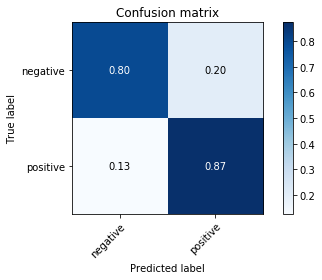

In [39]:
plot_confusion_matrix(y_test, y_pred, classes, normalize=True)

#### LSTM-CNN

In [40]:
model_weights_path = Path('/home/rmohashi/hd/tweet-emotion-recognition/models/sentiment_analysis/checkpoints/LSTM_Conv_50_30/lstm_conv_50_30_03-0.8149.h5').resolve()

In [41]:
start = time()
model = lstm_conv_model(input_length, input_dim, None, embedding_dim=embedding_dim)
model.load_weights(model_weights_path.as_posix())
x_test = pad_sequences(list_tokenized, maxlen=input_length)
y_pred = model.predict(x_test)
y_pred = y_pred.round()
print('Finished in: {} secs'.format(round((time() - start), 2)))
print(classification_report(y_test, y_pred, digits=4))

Finished in: 1.28 secs
              precision    recall  f1-score   support

           0     0.8623    0.8136    0.8372       177
           1     0.8281    0.8736    0.8503       182

    accuracy                         0.8440       359
   macro avg     0.8452    0.8436    0.8437       359
weighted avg     0.8450    0.8440    0.8438       359



Confusion matrix
[[0.81355932 0.18644068]
 [0.12637363 0.87362637]]


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f71f43abad0>)

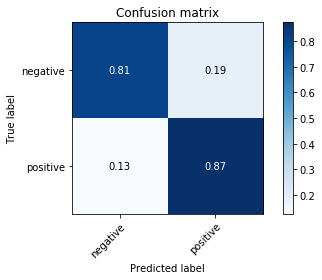

In [42]:
plot_confusion_matrix(y_test, y_pred, classes, normalize=True)

### 100d - no GloVe

In [43]:
embedding_dim = 100

#### LSTM

In [44]:
model_weights_path = Path('/home/rmohashi/hd/tweet-emotion-recognition/models/sentiment_analysis/checkpoints/LSTM_100_30/lstm_100_30_03-0.8150.h5').resolve()

In [45]:
model = lstm_model(input_length, input_dim, None, embedding_dim=embedding_dim)
model.load_weights(model_weights_path.as_posix())
x_test = pad_sequences(list_tokenized, maxlen=input_length)
y_pred = model.predict(x_test)
y_pred = y_pred.round()
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8580    0.7853    0.8201       177
           1     0.8071    0.8736    0.8391       182

    accuracy                         0.8301       359
   macro avg     0.8326    0.8295    0.8296       359
weighted avg     0.8322    0.8301    0.8297       359



Confusion matrix
[[0.78531073 0.21468927]
 [0.12637363 0.87362637]]


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f72072d7890>)

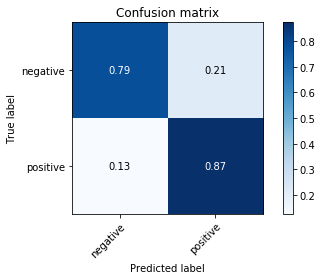

In [46]:
plot_confusion_matrix(y_test, y_pred, classes, normalize=True)

#### CNN

In [47]:
model_weights_path = Path('/home/rmohashi/hd/tweet-emotion-recognition/models/sentiment_analysis/checkpoints/CNN_100_30/cnn_100_30_02-0.8114.h5').resolve()

In [48]:
start = time()
model = cnn_model(input_length, input_dim, None, embedding_dim=embedding_dim)
model.load_weights(model_weights_path.as_posix())
x_test = pad_sequences(list_tokenized, maxlen=input_length)
y_pred = model.predict(x_test)
y_pred = y_pred.round()
print('Finished in: {} secs'.format(round((time() - start), 2)))
print(classification_report(y_test, y_pred, digits=4))

Finished in: 0.52 secs
              precision    recall  f1-score   support

           0     0.8623    0.8136    0.8372       177
           1     0.8281    0.8736    0.8503       182

    accuracy                         0.8440       359
   macro avg     0.8452    0.8436    0.8437       359
weighted avg     0.8450    0.8440    0.8438       359



Confusion matrix
[[0.81355932 0.18644068]
 [0.12637363 0.87362637]]


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f71faba3c50>)

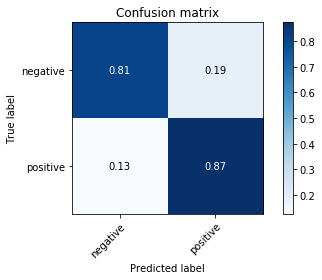

In [49]:
plot_confusion_matrix(y_test, y_pred, classes, normalize=True)

#### LSTM-CNN

In [50]:
model_weights_path = Path('/home/rmohashi/hd/tweet-emotion-recognition/models/sentiment_analysis/checkpoints/LSTM_Conv_100_30/lstm_conv_100_30_03-0.8154.h5').resolve()

In [51]:
start = time()
model = lstm_conv_model(input_length, input_dim, None, embedding_dim=embedding_dim)
model.load_weights(model_weights_path.as_posix())
x_test = pad_sequences(list_tokenized, maxlen=input_length)
y_pred = model.predict(x_test)
y_pred = y_pred.round()
print('Finished in: {} secs'.format(round((time() - start), 2)))
print(classification_report(y_test, y_pred, digits=4))

Finished in: 1.47 secs
              precision    recall  f1-score   support

           0     0.8580    0.8192    0.8382       177
           1     0.8316    0.8681    0.8495       182

    accuracy                         0.8440       359
   macro avg     0.8448    0.8437    0.8438       359
weighted avg     0.8446    0.8440    0.8439       359



Confusion matrix
[[0.81920904 0.18079096]
 [0.13186813 0.86813187]]


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f71fad689d0>)

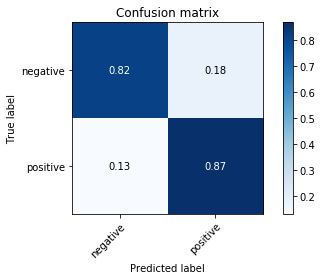

In [52]:
plot_confusion_matrix(y_test, y_pred, classes, normalize=True)